In [1]:
from regain.datasets.hmm import generate_hmm
from regain.hmm.hmm_graphical_lasso import HMM_GraphicalLasso 
import numpy as np
from importlib import reload
import regain.hmm.utils; reload(regain.hmm.utils)
from regain.hmm.utils import results_recap
from regain.hmm.utils import cross_validation#, cross_validation_auto
import pickle as pkl
from sklearn import cluster
from sklearn.mixture import GaussianMixture
from pomegranate import *

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/federicociech/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
st = 5
dim =10
mm = 'Normal'
cluster_list = [3,4,5,6,7,8]

res_all = {}

#if st == 2:
#    alpha_list = np.linspace(45,65 ,2)
#elif st == 5:
#    alpha_list = np.linspace(25,35 ,20)
#elif st == 10:
# alpha_list = np.linspace(15,25 ,20)
#elif st == 15:
#    alpha_list = np.linspace(5,15 ,20)


print('Case: N_states:',st,',TS dim:',dim,',Mean mode:',mm)

# Generate a dataset
dataset = generate_hmm(n_samples=2000,
                       n_states=st,
                       n_dim_obs=dim,
                       mode_precisions='regain_random',
                       mode_mean = mm,
                       transition_type='fixed',
                       sigma=1)

Case: N_states: 5 ,TS dim: 10 ,Mean mode: Normal


In [11]:
# CV hmm_gmm 

hmm_gmm = HMM_GraphicalLasso(alpha=30,
                             n_clusters=st,
                             verbose=False,
                             mode='scaled',
                             warm_restart=True,
                             repetitions=5,
                             n_jobs=-1)

hmm_gmm.fit(dataset['data'])

print(hmm_gmm.lambdas)

print(results_recap(dataset['states'],hmm_gmm.labels_,dataset['thetas'],hmm_gmm.precisions_))

[0.26144349 0.31327427 0.07121999 0.03187856 0.07022665]
{'homogeneity [0, 1]': 0.994675486547373, 'completeness [0, 1]': 0.9957203601816402, 'v_measure [0, 1]': 0.9951976491072746, 'adjusted_mutual_info [0, 1]': 0.9951828711804401, 'weighted_mean_mcc [-1, 1]': (0.5484826248336605,), 'max_cluster_mean_mcc[-1,1]': (0.549285527964732,), 'weighted_mean_f1 [0, 1]': (0.4871507077404645,), 'max_cluster_mean_f1[0,1]': (0.4874943220531455,), 'probabilities_clusters': (array([[0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.99763033, 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.00234742],
       [0.        , 1.        , 0.00236967, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.99765258]]),), 'max_probabilities_couples': ['Couple: (0, 3), Probability: 1.0, MCC: 0.5, F1_score: 0.3125', 'Couple: (2, 0), Probability: 1.0, MCC: 0.621581560508061, F1_score: 0.47619047619047616', '

In [ ]:
hmm_gmm.lambdas

In [12]:
res = cross_validation(hmm_gmm,
       dataset['data'],
       params={'alpha':np.linspace(15,30 ,10),
               'n_clusters':cluster_list},
       n_repetitions=5)

100%|██████████| 10/10 [9:05:51<00:00, 3275.18s/it]


In [17]:
with open('Test_bic.pickle', 'wb') as f:
    pkl.dump([dataset,res], f)

In [14]:
res_alpha_fede = res[1]
couples = []
mean_bic = []
std_bic =[]
dispersion_coeff = []
for k in res_alpha_fede.keys():
    couples.append(k)
    mean_bic.append(res_alpha_fede[k]['mean_bic'])
    std_bic.append(res_alpha_fede[k]['std_bic'])
    dispersion_coeff.append(res_alpha_fede[k]['dispersion_coefficient'])

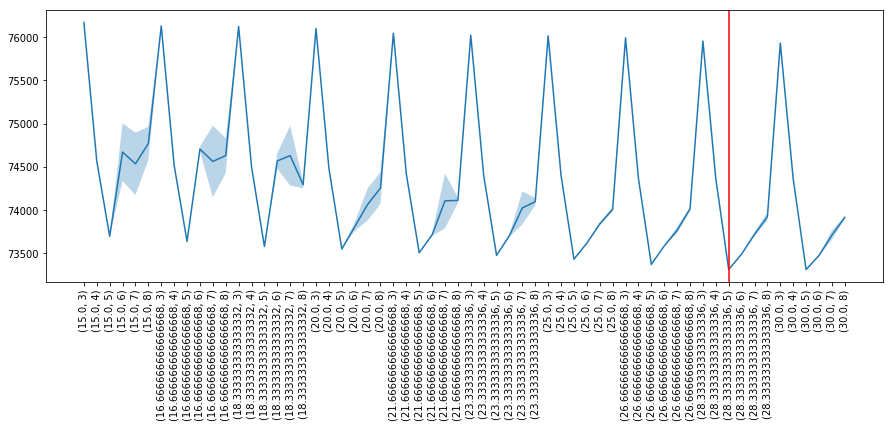

In [15]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,5))
plt.plot(mean_bic)
plt.fill_between(np.arange(len(mean_bic)), np.array(mean_bic)-np.array(std_bic),
                 np.array(mean_bic)+np.array(std_bic), alpha=0.3)
plt.axvline(np.argmin(mean_bic), color='red')
plt.xticks(np.arange(len(mean_bic)),couples, rotation='vertical')
plt.show()

#plt.figure(figsize=(15,10))
#plt.plot(dispersion_coeff)
#plt.axvline(np.argmin(dispersion_coeff), color='red')
#plt.xticks(np.arange(len(mean_bic)),couples, rotation='vertical')
#plt.show()

#plt.figure(figsize=(15,5))
#final_res = np.array(mean_bic/np.sum(mean_bic)) + np.array(dispersion_coeff)
#plt.plot(final_res)
#plt.axvline(np.argmin(final_res), color='red')
#plt.xticks(np.arange(len(mean_bic)),couples, rotation='vertical')
#plt.show()